# 1.Import Dependencies

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2.Keypoints using MP Holistic

In [2]:
# Holistic model
mp_holistic = mp.solutions.holistic 
# Drawing utilties
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image, model):
#     color conversion
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     Image is no longer writeable
    image.flags.writeable = False
#     Make prediction
    results = model.process(image)
#     image in now writeable
    image.flags.writeable = False
    #     color conversion
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks,
                             mp_holistic.FACEMESH_TESSELATION)
    
    mp_drawing.draw_landmarks(image, results.pose_landmarks,
                             mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks,
                    mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks,
                             mp_holistic.HAND_CONNECTIONS)

In [5]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks,
                             mp_holistic.FACEMESH_TESSELATION,
            mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=2,
            circle_radius=2),
            mp_drawing.DrawingSpec(color=(80,256,121), thickness=1,
            circle_radius=1))
    
    mp_drawing.draw_landmarks(image, results.pose_landmarks,
                             mp_holistic.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2,
            circle_radius=2),
            mp_drawing.DrawingSpec(color=(80,44,121), thickness=1,
            circle_radius=1))
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks,
                    mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2,
            circle_radius=2),
            mp_drawing.DrawingSpec(color=(121,44,250), thickness=1,
            circle_radius=1))
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks,
                             mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2,
            circle_radius=2),
            mp_drawing.DrawingSpec(color=(245,66,230), thickness=1,
            circle_radius=1))

In [21]:
# mp_drawing.draw_landmarks??

In [10]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, 
    min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        ret, frame = cap.read()
        #Make detection
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
            
        #Draw landmarks
#         draw_landmarks(image, results)
        draw_styled_landmarks(image, results)

        cv2.imshow('Opencv Feed', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [23]:
# x ->x-axis
# y->y-axis
# z-> distace from face to camera
# results.face_landmarks

In [12]:
draw_landmarks(frame,results)

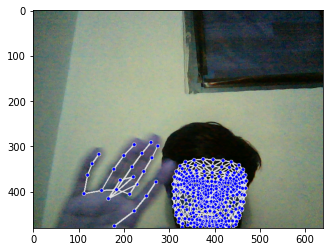

In [13]:
plt.imshow(frame)

# 3.Extract Keypoint Values

In [14]:
len(results.pose_landmarks.landmark)

33

In [15]:
len(results.left_hand_landmarks.landmark)

AttributeError: 'NoneType' object has no attribute 'landmark'

In [16]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

# Face,Pose, Left Hand, Right Landmarks

In [17]:
"""If landmarks exists it will return other wise it will retun the empty array of zeros"""
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)

lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3) 
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3) 

In [18]:
print(pose.shape)
print(face.shape)
print(lh.shape)
print(rh.shape)

(132,)
(1404,)
(63,)
(63,)


In [6]:
def extract_keypoints(results):
    """If landmarks exists it will return other wise it will retun the empty array of zeros"""
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)

    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3) 
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3) 
   
    return np.concatenate([pose, face, lh, rh])

In [20]:
output = extract_keypoints(results)
# output

# 4. Setup Folders for collection

In [7]:
# path for exported data, numpy arrays
DATA_PATH = os.path.join('MP2_Data')

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30
# videos are goining to be 30 frames in length
sequence_length = 30


In [35]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
#            print(e)
            pass

# 5. Collect Keypoint Values for Training and Testing

In [1]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, 
    min_tracking_confidence=0.5) as holistic:
    
#     Loop through actions
    for action in actions:
#         loop throug sequences videos
        for sequence in range(no_sequences):
            
#             Loop through video Length aka sequence lenght
            for frame_num in range(sequence_length):
                ret, frame = cap.read()
                #Make detection
                image, results = mediapipe_detection(frame, holistic)
        #         print(results)

                #Draw landmarks
        #         draw_landmarks(image, results)
                draw_styled_landmarks(image, results)

                #Apply collection logic
                if frame_num == 0:
                    #this line will show the message the video collection is started
                    cv2.putText(image, 'STARTING COLLECTION',(120,200),
                        cv2.FONT_HERSHEY_SIMPLEX, 1,
                        (0,255,0), 4, cv2.LINE_AA)
                    #show number of  frames collected for each video                
                    cv2.putText(image, 'Collecting frames for {} videos Number {}'.format(action, sequence),(15,12),
                      cv2.FONT_HERSHEY_COMPLEX, 0.5,
                        (0,0,255), 1, cv2.LINE_AA)
                    cv2.waitKey(2000)
                else:

                    cv2.putText(image, 'Collecting frames for {} videos Number {}'.format(action, sequence),(15,12),
                      cv2.FONT_HERSHEY_COMPLEX, 0.5,
                        (0,0,255), 1, cv2.LINE_AA)

                #New Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(frame_num))
                np.save(npy_path, keypoints)

                cv2.imshow('Opencv Feed', image)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
    cap.release()
    cv2.destroyAllWindows() 

NameError: name 'cv2' is not defined

# 6. Preprocess Data and Create Labels and Features

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [10]:
label_map = {label: num for num, label in enumerate(actions)}

In [11]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [41]:
DATA_PATH = 'MP_Data'
# store data and labels in these two lists
sequences, labels = [], []
# this loop is for all classes
for action in actions:
    #this loop is for all videos 
    for sequence in range(no_sequences):
        #in this list we will store all frames of single video         
        window = []
        #this loop is for all frames in each video         
        for frame_num in range(sequence_length):
            #load each frame from directory             
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            #add each frame in window list             
            window.append(res)
        #append list of frames of single video in sequence list             
        sequences.append(window)
        #add his lable in labels list         
        labels.append(label_map[action])

In [42]:
"""In output it will give us (90,30,1662) it means that total 90 videos 
30 frames per video and tota 1662 points"""
np.array(sequences).shape

(90, 30, 1662)

In [43]:
np.array(labels).shape

(90,)

In [14]:
X = np.array(sequences)


NameError: name 'sequences' is not defined

In [45]:
X.shape

(90, 30, 1662)

In [46]:
y = to_categorical(labels).astype(int)

In [47]:
y.shape

(90, 3)

# Split Data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.05)

NameError: name 'X' is not defined

In [ ]:
print(X_train.shape)
print(X_test.shape)

# 7. Build and Train LSTM Neural Network

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [3]:
log_dir = os.path.join('logs')
tb_callback = TensorBoard(log_dir=log_dir)

NameError: name 'os' is not defined

In [1]:
"""This is our model code in which we have build our model 
at first layer we have add 64 units and restun_sequence will return the output and it will
be passed to another layer and we have used activation ftn relu and input_shape is according
to our data
second and third layer is same in third layer return_sequence is false
because the next layer is Dense layer.
At the end we have use dense layer in which no of units equal to number of classes and
activation function is softmax function.
"""
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))



NameError: name 'Sequential' is not defined

In [53]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

In [54]:
model.fit(X_train, y_train, epochs=140, callbacks=[tb_callback])

Epoch 1/140
3/3 [==============================] - 12s 149ms/step - loss: 3.6816 - categorical_accuracy: 0.3412
Epoch 2/140
3/3 [==============================] - 1s 195ms/step - loss: 1.3131 - categorical_accuracy: 0.3882
Epoch 3/140
3/3 [==============================] - 1s 170ms/step - loss: 1.2020 - categorical_accuracy: 0.3176
Epoch 4/140
3/3 [==============================] - 0s 160ms/step - loss: 1.1569 - categorical_accuracy: 0.3176
Epoch 5/140
3/3 [==============================] - 0s 148ms/step - loss: 1.3972 - categorical_accuracy: 0.6118
Epoch 6/140
3/3 [==============================] - 0s 171ms/step - loss: 1.0321 - categorical_accuracy: 0.4706
Epoch 7/140
3/3 [==============================] - 0s 156ms/step - loss: 1.1177 - categorical_accuracy: 0.3529
Epoch 8/140
3/3 [==============================] - 0s 158ms/step - loss: 0.9743 - categorical_accuracy: 0.5647
Epoch 9/140
3/3 [==============================] - 0s 157ms/step - loss: 0.9324 - categorical_accuracy: 0.5529


In [66]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-trai

# 8. Make Predictions

In [67]:
res = model.predict(X_test)

1/1 [==============================] - 0s 63ms/step


In [68]:
actions[np.argmax(res[4])]

'hello'

In [69]:
actions[np.argmax(y_test[4])]

'hello'

# 9. Save Weights

In [70]:
model.save('action.h5')

In [7]:
from tensorflow.keras.models import load_model
model = load_model('./action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [11]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [9]:
yhat = model.predict(X_test)

NameError: name 'X_test' is not defined

In [74]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [75]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[4, 0],
        [0, 1]],

       [[4, 0],
        [0, 1]],

       [[2, 0],
        [0, 3]]], dtype=int64)

In [76]:
accuracy_score(ytrue, yhat)

1.0

# 11. Test in Real Time

In [16]:
from  tensorflow.keras.models import load_model
model = load_model('action.h5')

In [19]:
import cv2
sequence = []
sentence = []
threshold = 0.4

cap = cv2.VideoCapture(0)
cap.set(3, 640)
cap.set(4, 500)
with mp_holistic.Holistic(min_detection_confidence=0.5, 
    min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        ret, frame = cap.read()
        #Make detection
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
            
        #Draw landmarks
#         draw_styled_landmarks(image, results)
       #prediction logic
        keypoints = extract_keypoints(results)
#         print(keypoints)
        sequence.insert(0,keypoints)
        sequence = sequence[:30]  
#         print(sequence)
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
#             print(actions[np.argmax(res)])
        
        
            #vis logic
            if np.argmax(res) < res.shape[0]:
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
                if len(sentence) > 5:
                    sentence = sentence[-5:]

                cv2.rectangle(image, (0,0), (640,40),(245, 117, 16),
                             -1)
                cv2.putText(image, ' '.join(sentence), (3, 30),
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255,255), 2, cv2.LINE_AA)
        cv2.imshow('Opencv Feed', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 61ms/step


In [15]:
cap.release()
cv2.destroyAllWindows()

In [59]:
arr = np.array([1,2,3,4,5])
lst = arr.tolist()

In [60]:
print(lst)
print(np.sort(arr))
print(np.max(arr))
print(np.min(arr))

[1, 2, 3, 4, 5]
[1 2 3 4 5]
5
1


In [61]:
arr2 = np.array([[4,3],[1,2]])
print(np.sort(arr2, axis=0))
[4,3]
[1,2]

[[1 2]
 [4 3]]


[1, 2]

In [62]:
lst = [1,2,3,4,5,6,7,8,9,10]
print(lst[:-5])

[1, 2, 3, 4, 5]
